In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install transformers tensorflow torch torchvision matplotlib scikit-learn

import os

fabrika_path = '/content/drive/MyDrive/Yazılım_Gelistirme_Labaratuvarı_Proje/Hava_Kirliligi/Fabrika/Fabrika_Veriler'
tasit_path = '/content/drive/MyDrive/Yazılım_Gelistirme_Labaratuvarı_Proje/Hava_Kirliligi/Tasit/Tasit_Veriler'

print("Fabrika Verileri:")
for root, dirs, files in os.walk(fabrika_path):
    print(f"Klasör: {root}, Görsel Sayısı: {len(files)}")

print("\nMotorlu Taşıtlar Verileri:")
for root, dirs, files in os.walk(tasit_path):
    print(f"Klasör: {root}, Görsel Sayısı: {len(files)}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Fabrika Verileri:
Klasör: /content/drive/MyDrive/Yazılım_Gelistirme_Labaratuvarı_Proje/Hava_Kirliligi/Fabrika/Fabrika_Veriler, Görsel Sayısı: 12041

Motorlu Taşıtlar Verileri:
Klasör: /content/drive/MyDrive/Yazılım_Gelistirme_Labaratuvarı_Proje/Hava_Kirliligi/Tasit/Tasit_Veriler, Görsel Sayısı: 13359


In [ ]:
import tensorflow as tf
import os

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU bellek büyümesi etkinleştirildi")
    except RuntimeError as e:
        print(e)

fabrika_path = '/content/drive/MyDrive/Yazılım_Gelistirme_Labaratuvarı_Proje/Hava_Kirliligi/Fabrika/Fabrika_Veriler'
tasit_path = '/content/drive/MyDrive/Yazılım_Gelistirme_Labaratuvarı_Proje/Hava_Kirliligi/Tasit/Tasit_Veriler'

IMG_SIZE = (224, 224)

def preprocess_dataset(image_folder, label):
    dataset = tf.data.Dataset.list_files(f"{image_folder}/*", shuffle=True)

    def process_path(file_path):
        img = tf.io.read_file(file_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, IMG_SIZE)
        img = img / 255.0
        return img, label

    return dataset.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

fabrika_dataset = preprocess_dataset(fabrika_path, 0)
tasit_dataset = preprocess_dataset(tasit_path, 1)

total_dataset = fabrika_dataset.concatenate(tasit_dataset)
total_dataset = total_dataset.shuffle(10000)

train_size = int(0.8 * len(list(total_dataset)))
train_dataset = total_dataset.take(train_size)
test_dataset = total_dataset.skip(train_size)

train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

print(f"Eğitim seti: {len(list(train_dataset))} batch")
print(f"Test seti: {len(list(test_dataset))} batch")


Eğitim seti: 635 batch
Test seti: 159 batch


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 543s 808ms/step - accuracy: 0.8082 - loss: 0.3941 - val_accuracy: 0.7331 - val_loss: 0.5805
Epoch 2/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 545s 824ms/step - accuracy: 0.4958 - loss: 0.6908 - val_accuracy: 0.7301 - val_loss: 0.6210
Epoch 3/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 569s 841ms/step - accuracy: 0.3523 - loss: 0.7447 - val_accuracy: 0.7409 - val_loss: 0.6318
Epoch 4/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 585s 887ms/step - accuracy: 0.3832 - loss: 0.7259 - val_accuracy: 0.7443 - val_loss: 0.6388
Epoch 5/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 577s 873ms/step - accuracy: 0.4066 - loss: 0.7167 - val_accuracy: 0.7372 - val_loss: 0.6435
Epoch 6/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 567s 859ms/step - accuracy: 0.4168 - loss: 0.7129 - val_accuracy: 0.7352 - val_loss: 0.6440
Epoch 7/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 537s 811ms/step - accuracy: 0.4145 - loss: 0.7130 - val_accuracy: 0.7289 - val_loss: 0.6465
Epoch 8/10
635/635 ━━━━━━

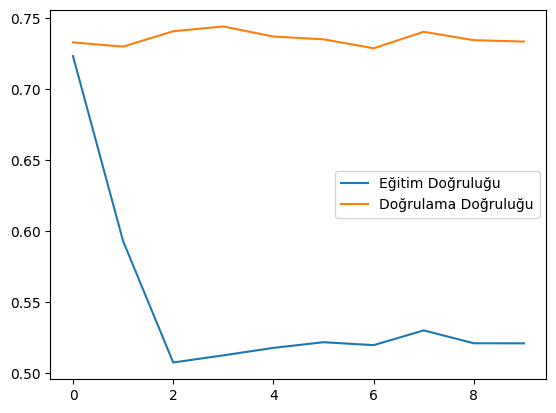

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_dataset, validation_data=test_dataset, epochs=10)

import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.legend()
plt.show()


In [ ]:
import os
import shutil

base_path = '/content/drive/MyDrive/Yazılım_Gelistirme_Labaratuvarı_Proje/Hava_Kirliligi'
fabrika_src = os.path.join(base_path, 'Fabrika/Fabrika_Veriler')
tasit_src = os.path.join(base_path, 'Tasit/Tasit_Veriler')

target_path = os.path.join(base_path, 'Veriler')
fabrika_target = os.path.join(target_path, 'Fabrika')
tasit_target = os.path.join(target_path, 'Tasit')

os.makedirs(fabrika_target, exist_ok=True)
os.makedirs(tasit_target, exist_ok=True)

for file_name in os.listdir(fabrika_src):
    src_file = os.path.join(fabrika_src, file_name)
    dst_file = os.path.join(fabrika_target, file_name)
    shutil.move(src_file, dst_file)

for file_name in os.listdir(tasit_src):
    src_file = os.path.join(tasit_src, file_name)
    dst_file = os.path.join(tasit_target, file_name)
    shutil.move(src_file, dst_file)

print("Klasörler başarıyla düzenlendi.")


Klasörler başarıyla düzenlendi.


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Train Loss: 0.08602353450218876, Validation Loss: 0.050156798676452924
Epoch 2, Train Loss: 0.028368875700760427, Validation Loss: 0.047057778404662444
Epoch 3, Train Loss: 0.019409072221491457, Validation Loss: 0.04484176035141631
Classification Report:
              precision    recall  f1-score   support

     Fabrika       0.98      0.99      0.99      2449
       Tasit       0.99      0.98      0.99      2631

    accuracy                           0.99      5080
   macro avg       0.99      0.99      0.99      5080
weighted avg       0.99      0.99      0.99      5080

Sensitivity: 0.98
Specificity: 0.99


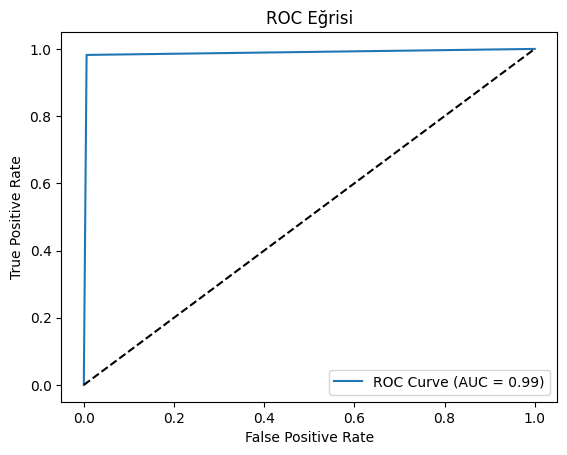

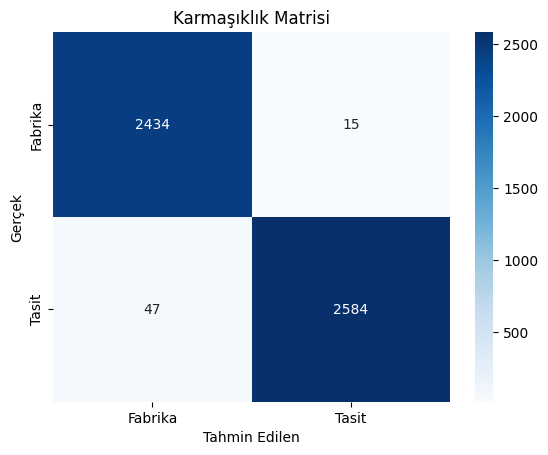

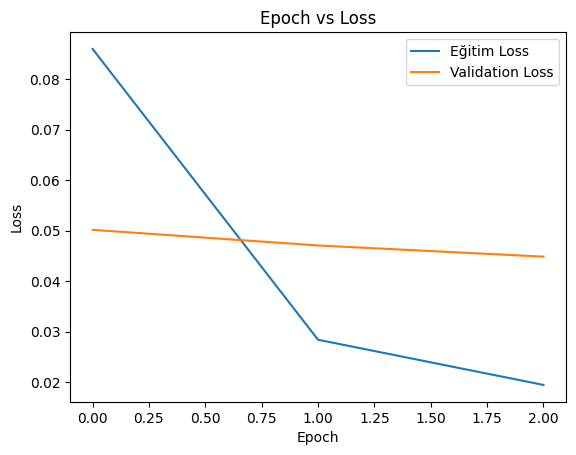

Eğitim Süresi: 32219.38 saniye
Çıkarım Süresi: 851.59 saniye


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import time
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import ViTForImageClassification, ViTFeatureExtractor
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
])

data_path = '/content/drive/MyDrive/Yazılım_Gelistirme_Labaratuvarı_Proje/Hava_Kirliligi/Veriler'
dataset = datasets.ImageFolder(root=data_path, transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=2)
model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
loss_fn = torch.nn.CrossEntropyLoss()

train_losses, val_losses = [], []
start_time = time.time()
for epoch in range(3):
    model.train()
    total_loss = 0
    for batch in train_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs).logits
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_losses.append(total_loss / len(train_loader))

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).logits
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()
    val_losses.append(val_loss / len(test_loader))
    print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")
end_time = time.time()
training_time = end_time - start_time

inference_start = time.time()
y_true, y_pred = [], []
with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs).logits
        predictions = torch.argmax(outputs, dim=-1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())
inference_end = time.time()
inference_time = inference_end - inference_start

from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=dataset.classes))

conf_matrix = confusion_matrix(y_true, y_pred)
TP = conf_matrix[1, 1]
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
print(f"Sensitivity: {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")

fpr, tpr, _ = roc_curve(y_true, y_pred, pos_label=1)
auc_score = roc_auc_score(y_true, y_pred)
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Eğrisi")
plt.legend()
plt.show()

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")
plt.title("Karmaşıklık Matrisi")
plt.show()

plt.plot(train_losses, label="Eğitim Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.show()

print(f"Eğitim Süresi: {training_time:.2f} saniye")
print(f"Çıkarım Süresi: {inference_time:.2f} saniye")


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/deit/feature_extraction_deit.py:28: FutureWarning: The class DeiTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DeiTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/349M [00:00<?, ?B/s]

Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Train Loss: 0.06599989565626506, Validation Loss: 0.03164525710869252
Epoch 2, Train Loss: 0.014200233568829383, Validation Loss: 0.03430877626967271
Epoch 3, Train Loss: 0.009049842611409441, Validation Loss: 0.027959955657705385
Classification Report:
              precision    recall  f1-score   support

     Fabrika       0.99      0.99      0.99      2469
       Tasit       0.99      0.99      0.99      2611

    accuracy                           0.99      5080
   macro avg       0.99      0.99      0.99      5080
weighted avg       0.99      0.99      0.99      5080

Sensitivity: 0.99
Specificity: 0.99


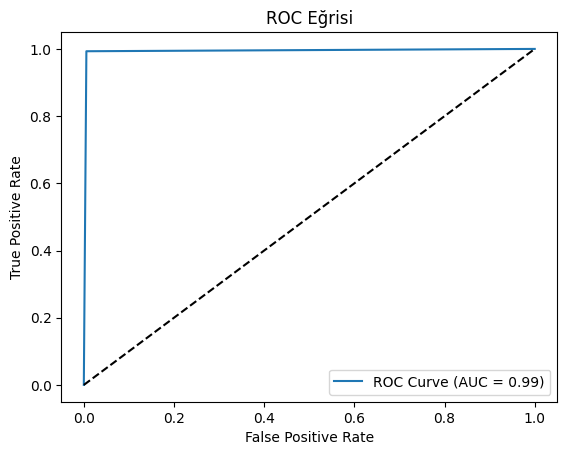

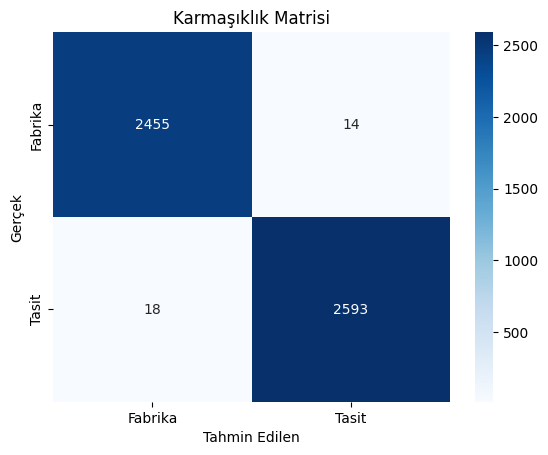

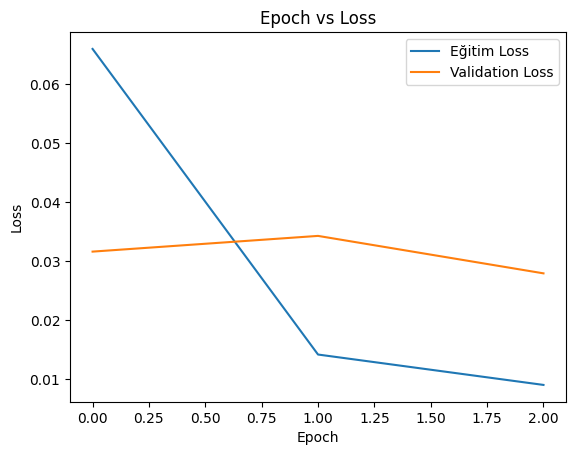

Eğitim Süresi: 32638.19 saniye
Çıkarım Süresi: 841.46 saniye


In [6]:
from transformers import DeiTForImageClassification, DeiTFeatureExtractor
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

feature_extractor = DeiTFeatureExtractor.from_pretrained("facebook/deit-base-distilled-patch16-224")
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
])

data_path = '/content/drive/MyDrive/Yazılım_Gelistirme_Labaratuvarı_Proje/Hava_Kirliligi/Veriler'
dataset = datasets.ImageFolder(root=data_path, transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = DeiTForImageClassification.from_pretrained("facebook/deit-base-distilled-patch16-224", num_labels=2)
model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
loss_fn = torch.nn.CrossEntropyLoss()

train_losses, val_losses = [], []
start_time = time.time()
for epoch in range(3):
    model.train()
    total_loss = 0
    for batch in train_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs).logits
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_losses.append(total_loss / len(train_loader))

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).logits
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()
    val_losses.append(val_loss / len(test_loader))
    print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")
end_time = time.time()
training_time = end_time - start_time

inference_start = time.time()
y_true, y_pred = [], []
with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs).logits
        predictions = torch.argmax(outputs, dim=-1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())
inference_end = time.time()
inference_time = inference_end - inference_start

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=dataset.classes))

conf_matrix = confusion_matrix(y_true, y_pred)
TP = conf_matrix[1, 1]
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
print(f"Sensitivity: {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")

fpr, tpr, _ = roc_curve(y_true, y_pred, pos_label=1)
auc_score = roc_auc_score(y_true, y_pred)
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Eğrisi")
plt.legend()
plt.show()

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")
plt.title("Karmaşıklık Matrisi")
plt.show()

plt.plot(train_losses, label="Eğitim Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.show()

print(f"Eğitim Süresi: {training_time:.2f} saniye")
print(f"Çıkarım Süresi: {inference_time:.2f} saniye")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/276 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/beit/feature_extraction_beit.py:28: FutureWarning: The class BeitFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use BeitImageProcessor instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/utils/deprecation.py:165: UserWarning: The following named arguments are not valid for `BeitFeatureExtractor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


config.json:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/414M [00:00<?, ?B/s]

Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224-pt22k-ft22k and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([21841, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([21841]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Train Loss: 0.07724765260707528, Validation Loss: 0.03962227256760681
Epoch 2, Train Loss: 0.026924575750686696, Validation Loss: 0.041380136293569965
Epoch 3, Train Loss: 0.02212869774251828, Validation Loss: 0.04102452892979238
Classification Report:
              precision    recall  f1-score   support

     Fabrika       0.99      0.98      0.98      2388
       Tasit       0.98      0.99      0.99      2692

    accuracy                           0.99      5080
   macro avg       0.99      0.98      0.99      5080
weighted avg       0.99      0.99      0.99      5080

Sensitivity: 0.99
Specificity: 0.98


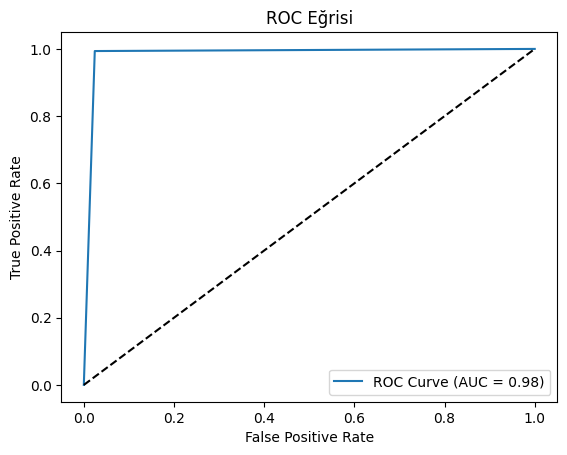

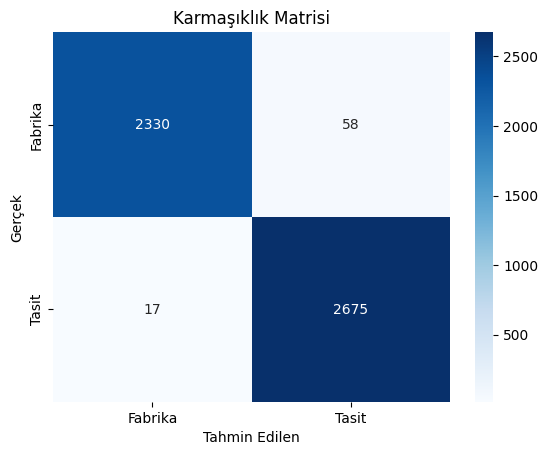

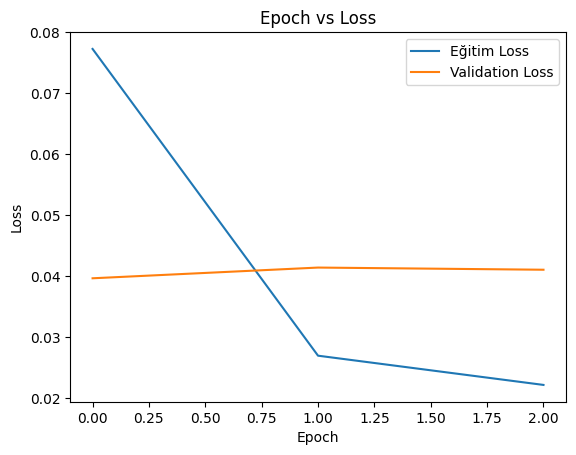

Eğitim Süresi: 34946.67 saniye
Çıkarım Süresi: 789.98 saniye


In [1]:
from transformers import BeitForImageClassification, BeitFeatureExtractor
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

feature_extractor = BeitFeatureExtractor.from_pretrained("microsoft/beit-base-patch16-224-pt22k-ft22k")
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
])

data_path = '/content/drive/MyDrive/Yazılım_Gelistirme_Labaratuvarı_Proje/Hava_Kirliligi/Veriler'
dataset = datasets.ImageFolder(root=data_path, transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = BeitForImageClassification.from_pretrained(
    "microsoft/beit-base-patch16-224-pt22k-ft22k",
    num_labels=2,
    ignore_mismatched_sizes=True
)
model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
loss_fn = torch.nn.CrossEntropyLoss()

train_losses, val_losses = [], []
start_time = time.time()
for epoch in range(3):
    model.train()
    total_loss = 0
    for batch in train_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs).logits
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_losses.append(total_loss / len(train_loader))

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).logits
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()
    val_losses.append(val_loss / len(test_loader))
    print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")
end_time = time.time()
training_time = end_time - start_time

inference_start = time.time()
y_true, y_pred = [], []
with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs).logits
        predictions = torch.argmax(outputs, dim=-1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())
inference_end = time.time()
inference_time = inference_end - inference_start

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=dataset.classes))

conf_matrix = confusion_matrix(y_true, y_pred)
TP = conf_matrix[1, 1]
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
print(f"Sensitivity: {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")

fpr, tpr, _ = roc_curve(y_true, y_pred, pos_label=1)
auc_score = roc_auc_score(y_true, y_pred)
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Eğrisi")
plt.legend()
plt.show()

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")
plt.title("Karmaşıklık Matrisi")
plt.show()

plt.plot(train_losses, label="Eğitim Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.show()

print(f"Eğitim Süresi: {training_time:.2f} saniye")
print(f"Çıkarım Süresi: {inference_time:.2f} saniye")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 150MB/s] 


Epoch 1, Train Loss: 0.12297846447808419, Validation Loss: 0.043795826581289186
Epoch 2, Train Loss: 0.034852705302365915, Validation Loss: 0.022626209945517516
Epoch 3, Train Loss: 0.01948281630883305, Validation Loss: 0.0197058224430236
Classification Report:
              precision    recall  f1-score   support

     Fabrika       0.99      0.99      0.99      2446
       Tasit       1.00      0.99      0.99      2634

    accuracy                           0.99      5080
   macro avg       0.99      0.99      0.99      5080
weighted avg       0.99      0.99      0.99      5080

Sensitivity: 0.99
Specificity: 0.99


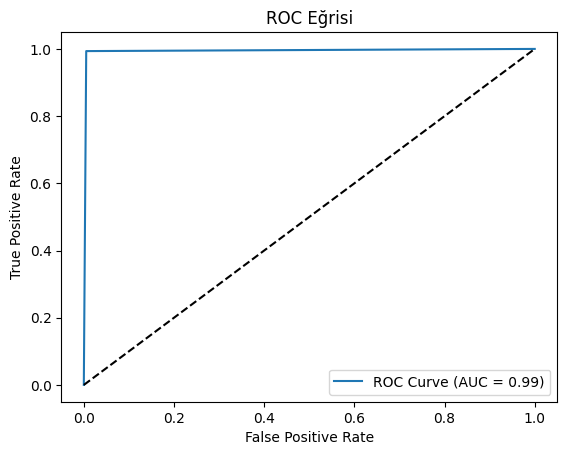

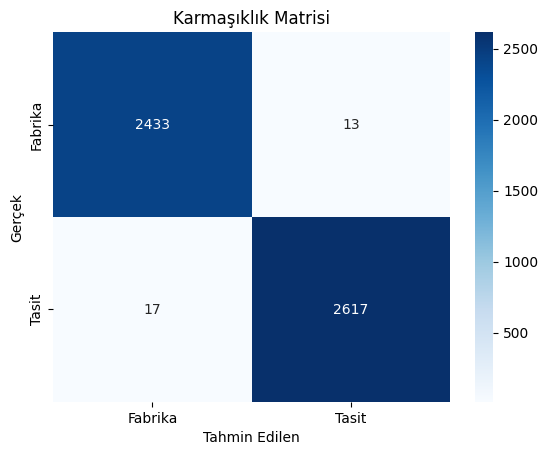

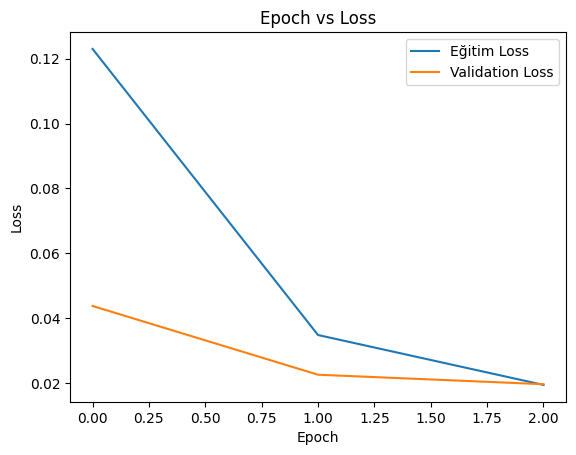

Eğitim Süresi: 3305.98 saniye
Çıkarım Süresi: 96.39 saniye


In [2]:
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
import torch
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

data_path = '/content/drive/MyDrive/Yazılım_Gelistirme_Labaratuvarı_Proje/Hava_Kirliligi/Veriler'
dataset = datasets.ImageFolder(root=data_path, transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = models.efficientnet_b0(pretrained=True)
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, 2)
model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
loss_fn = torch.nn.CrossEntropyLoss()

train_losses, val_losses = [], []
start_time = time.time()
for epoch in range(3):
    model.train()
    total_loss = 0
    for batch in train_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_losses.append(total_loss / len(train_loader))

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()
    val_losses.append(val_loss / len(test_loader))
    print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")
end_time = time.time()
training_time = end_time - start_time

inference_start = time.time()
y_true, y_pred = [], []
with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predictions = torch.argmax(outputs, dim=-1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())
inference_end = time.time()
inference_time = inference_end - inference_start

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=dataset.classes))

conf_matrix = confusion_matrix(y_true, y_pred)
TP = conf_matrix[1, 1]
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
print(f"Sensitivity: {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")

fpr, tpr, _ = roc_curve(y_true, y_pred, pos_label=1)
auc_score = roc_auc_score(y_true, y_pred)
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Eğrisi")
plt.legend()
plt.show()

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")
plt.title("Karmaşıklık Matrisi")
plt.show()

plt.plot(train_losses, label="Eğitim Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.show()

print(f"Eğitim Süresi: {training_time:.2f} saniye")
print(f"Çıkarım Süresi: {inference_time:.2f} saniye")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/71.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/113M [00:00<?, ?B/s]

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Train Loss: 0.08345580184960547, Validation Loss: 0.04730187782596024
Epoch 2, Train Loss: 0.03267803534223262, Validation Loss: 0.03005136456011074
Epoch 3, Train Loss: 0.026057147955434914, Validation Loss: 0.030126217927867197
Classification Report:
              precision    recall  f1-score   support

     Fabrika       0.99      0.99      0.99      2423
       Tasit       0.99      0.99      0.99      2657

    accuracy                           0.99      5080
   macro avg       0.99      0.99      0.99      5080
weighted avg       0.99      0.99      0.99      5080

Sensitivity: 0.99
Specificity: 0.99


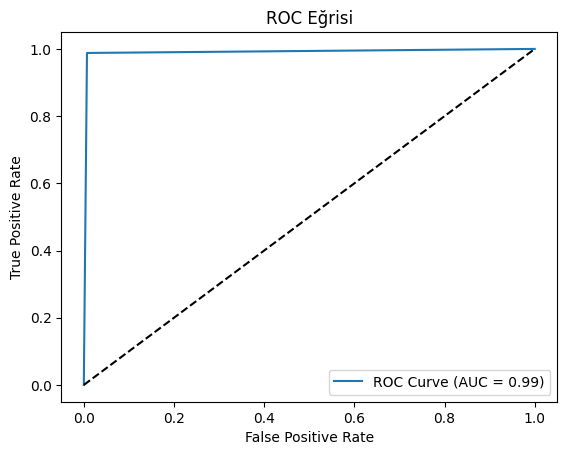

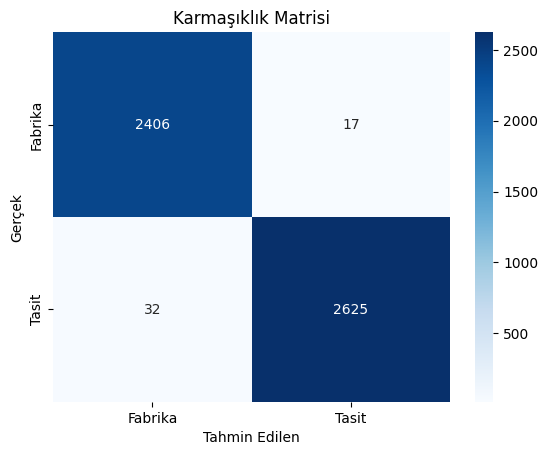

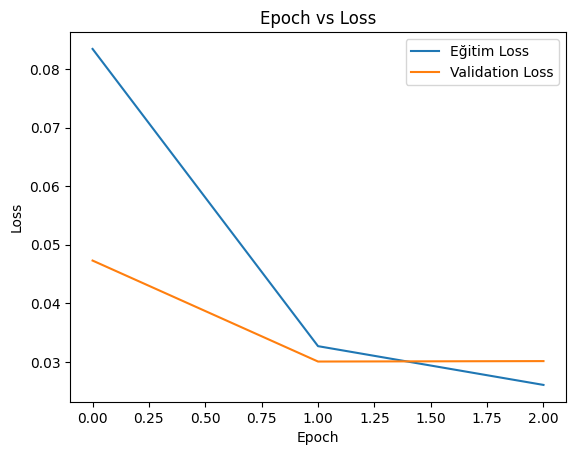

Eğitim Süresi: 58981.40 saniye
Çıkarım Süresi: 1349.00 saniye


In [1]:
from transformers import AutoFeatureExtractor, SwinForImageClassification
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import time

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

data_path = '/content/drive/MyDrive/Yazılım_Gelistirme_Labaratuvarı_Proje/Hava_Kirliligi/Veriler'
dataset = datasets.ImageFolder(root=data_path, transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = SwinForImageClassification.from_pretrained(
    "microsoft/swin-tiny-patch4-window7-224",
    num_labels=2,
    ignore_mismatched_sizes=True
)
model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
loss_fn = torch.nn.CrossEntropyLoss()

train_losses, val_losses = [], []
start_time = time.time()
for epoch in range(3):
    model.train()
    total_loss = 0
    for batch in train_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(pixel_values=inputs).logits
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_losses.append(total_loss / len(train_loader))

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(pixel_values=inputs).logits
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()
    val_losses.append(val_loss / len(test_loader))
    print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")
end_time = time.time()
training_time = end_time - start_time

inference_start = time.time()
y_true, y_pred = [], []
with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(pixel_values=inputs).logits
        predictions = torch.argmax(outputs, dim=-1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())
inference_end = time.time()
inference_time = inference_end - inference_start

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=dataset.classes))

conf_matrix = confusion_matrix(y_true, y_pred)
TP = conf_matrix[1, 1]
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
print(f"Sensitivity: {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")

fpr, tpr, _ = roc_curve(y_true, y_pred, pos_label=1)
auc_score = roc_auc_score(y_true, y_pred)
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Eğrisi")
plt.legend()
plt.show()

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")
plt.title("Karmaşıklık Matrisi")
plt.show()

plt.plot(train_losses, label="Eğitim Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.show()

print(f"Eğitim Süresi: {training_time:.2f} saniye")
print(f"Çıkarım Süresi: {inference_time:.2f} saniye")